# Diversity of Ideas: Harvard

## Setup

In [1]:
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())

True

In [2]:
import pandas as pd
from util.ouraws import (
    getFromFile
)

In [3]:
%pwd

'c:\\Users\\theod\\OneDrive\\dev\\diversity-ideas\\notebooks\\2024'

In [4]:
op_eds_df = getFromFile("../../data/harvard-op-eds.parquet", False)
editorials_df = getFromFile("../../data/harvard-editorials.parquet", False)
columns_df = getFromFile("../../data/harvard-columns.parquet", False)

df = pd.concat([op_eds_df, editorials_df, columns_df], ignore_index=True)
df.shape


(8672, 6)

In [5]:
df.shape, op_eds_df.shape, editorials_df.shape, columns_df.shape

((8672, 6), (3026, 6), (2055, 6), (3591, 6))

In [6]:
df.head(4)

,title,url,body,year,month,day
0,"Allston Is Gentrifying, but Harvard Isn’t To B...",https://www.thecrimson.com/article/2024/3/7/be...,"Allston Is Gentrifying, but Harvard Isn’t To B...",2024,3,1
1,Datamatch’s Flaws Run Deeper Than a Leak,https://www.thecrimson.com/article/2024/3/6/ra...,Datamatch’s Flaws Run Deeper Than a Leak\nBy T...,2024,3,1
2,"This Women’s History Month, I Find Myself in G...",https://www.thecrimson.com/article/2024/3/8/ch...,"This Women’s History Month, I Find Myself in G...",2024,3,1
3,A Safer River Run is a Better River Run,https://www.thecrimson.com/article/2024/3/5/me...,A Safer River Run is a Better River Run\nBy Ju...,2024,3,1


## Function Definitions

In [7]:
import numpy as np
import re

In [8]:
def getCovDispersion(wv):
    """
    Calculate various dispersion measures using the covariance matrix of word vectors.
    
    Args:
        wv: numpy array of shape (n_documents, embedding_dim) containing document embeddings
        
    Returns:
        tuple containing:
        - N: number of documents
        - trace_norm: average variance along the diagonal
        - l1_norm: L1 norm of covariance matrix (normalized)
        - l2_norm: L2 norm of covariance matrix (normalized)
        - inf_norm: Infinity norm of covariance matrix (normalized)
    """
    # Get number of documents
    N = len(wv)
    
    # Calculate covariance matrix of the word vectors
    # This measures how dimensions vary together across documents
    cov = np.cov(wv)
    
    return (
        N,  # Number of documents
        np.trace(cov)/N,  # Average variance along diagonal (spread in each dimension)
        np.linalg.norm(cov, ord=1)/N,  # L1 norm (sum of absolute values)
        np.linalg.norm(cov, ord=2)/N,  # L2/Spectral norm (largest singular value)
        np.linalg.norm(cov, ord=np.inf)/N,  # Infinity norm (max absolute row sum)
    )

def cosine_distance(v1, v2):
    """Calculate the cosine distance between two numpy arrays.
    
    Parameters:
    a (numpy array): First input array.
    b (numpy array): Second input array.
    
    Returns:
    float: Cosine distance between a and b.
    """
    a = np.array(v1, dtype=np.float64)
    b = np.array(v2, dtype=np.float64)
    # Calculate dot product and magnitudes of the input arrays
    dot   = np.dot(a, b)
    a_mag = np.linalg.norm(a)
    b_mag = np.linalg.norm(b)
    
    if np.isclose(a_mag, 0, rtol=1e-9, atol=1e-12):
        print(f"a_mag is very small: {a_mag}")
    if np.isclose(b_mag, 0, rtol=1e-9, atol=1e-12):
        print(f"b_mag is very small: {b_mag}")
    
    # Calculate and return the cosine distance
    return 1.0 - (dot / (a_mag * b_mag))

def getPairwiseDispersion(wv, measure):
    if len(wv) <= 1: return 0.0
    distance = 0.0
    vec = wv[0]
    for v in wv[1:]:
        distance += measure(vec, v)
        # print(f"\tcos_distance: {measure(vec, v)}")
    return distance + getPairwiseDispersion(wv[1:], measure)

def getNormalizedPairwiseDispersion(wv, measure):
    '''Normalize the dispersion by (N-Choose-2) number of pairs'''
    N = len(wv)
    return getPairwiseDispersion(wv, measure) / (N * (N-1)/2.)

In [9]:
diversity_words = [
    'diversity', 
    'equity',
    'inclusion',
    'inclusive',
    'inclusivity',
    'equality', 
    'equal opportunity',
    'social justice',
    'racial justice', 
    'multi-cultural', 
    'multicultural',
    'intercultural',
    'intersectional',
    'intersectionality',
    'anti-discrimination'
]

In [10]:
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\theod\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [11]:
diversity_lemmas = [lemmatizer.lemmatize(w) for w in diversity_words]
diversity_lemmas

['diversity',
 'equity',
 'inclusion',
 'inclusive',
 'inclusivity',
 'equality',
 'equal opportunity',
 'social justice',
 'racial justice',
 'multi-cultural',
 'multicultural',
 'intercultural',
 'intersectional',
 'intersectionality',
 'anti-discrimination']

In [12]:
diversity_pattern = "|".join(diversity_lemmas)

Let's verify how the "count" of diversity words in the text is calculated.

In [13]:
text = "This is a multicultural organization that advocates for diversity and racial justice."
len(re.findall(diversity_pattern, text))

3

## Analysis

In [14]:
from openai import OpenAI
from typing import List
import numpy as np
client = OpenAI()

In [15]:
def get_embedding(text: str) -> List[float]:
    """
    Get embeddings for a single text using text-embedding-3-large model.
    
    Args:
        text (str): The input text to generate embeddings for
        
    Returns:
        List[float]: The embedding vector
    """
    response = client.embeddings.create(
        model="text-embedding-3-large",
        input=text,
        dimensions=1024  # Optional: You can specify 256, 512, or 1024 dimensions
    )
    return response.data[0].embedding

def get_batch_embeddings(texts: List[str]) -> List[List[float]]:
    """
    Get embeddings for multiple texts in a single API call.
    
    Args:
        texts (List[str]): List of input texts to generate embeddings for
        
    Returns:
        List[List[float]]: List of embedding vectors
    """
    response = client.embeddings.create(
        model="text-embedding-3-large",
        input=texts,
        dimensions=1024
    )
    return [item.embedding for item in response.data]

In [16]:
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\theod\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
english_stopwords = stopwords.words('english')
def prepText(text_series):
    # Step 1: Clean and normalize each text in the series
    # - Convert to lowercase
    # - Lemmatize each word (convert to base form)
    # - Remove stopwords
    # - Join words back together with spaces
    text_series = text_series.apply(
        lambda x: " ".join(lemmatizer.lemmatize(w.lower()) for w in x.split()
                           if w not in english_stopwords))
    
    # Step 2: Filter out short texts
    # Remove any text less than 100 characters as they're likely too short for meaningful analysis
    text_series = text_series.apply(lambda x: x if len(x) > 100 else None)
    
    # Step 3: Remove any null values created by the previous step
    text_series = text_series.dropna()
    
    # Step 4: Count diversity-related terms
    # Sum up all instances of diversity-related words (defined in diversity_pattern)
    # across all remaining texts in the series
    total_diversity_words = sum([len(re.findall(diversity_pattern, text))
                                for text in text_series])
    
    # Return both the cleaned text series and the total count of diversity words
    return text_series, total_diversity_words

In [18]:
START_YEAR = 2009
FINAL_YEAR = 2024

In [19]:
year_2024 = df[df.year==2024]
clean_df, num_diversity_words = prepText(year_2024.body)
wv = get_batch_embeddings(clean_df)

In [20]:
type(wv[0])

list

In [21]:
docmatrix = np.array(wv)

In [22]:
docmatrix.shape

(439, 1024)

In [23]:
pairwise = getNormalizedPairwiseDispersion(docmatrix, cosine_distance)
cov = getCovDispersion(docmatrix)
print(f"{year_2024.year}, {cov[0]}, {cov[1]}, {pairwise}")

0       2024
1       2024
2       2024
3       2024
4       2024
        ... 
8224    2024
8226    2024
8229    2024
8230    2024
8232    2024
Name: year, Length: 443, dtype: int64, 439, 0.0009771121350082216, 0.418339870771561


In [24]:
pairwise

0.418339870771561

In [25]:
def chunk_process_embeddings(clean_df):
    """
    Process embeddings in chunks and combine results.
    
    Args:
        clean_df: pandas Series of cleaned text
    
    Returns:
        List of embeddings
    """
    # Calculate chunk size (divide into 3 equal parts)
    chunk_size = len(clean_df) // 3
    
    # Split into 3 chunks
    chunks = [
        clean_df[i:i + chunk_size] 
        for i in range(0, len(clean_df), chunk_size)
    ]
    
    # Process each chunk and combine results
    all_embeddings = []
    for chunk in chunks:
        chunk_embeddings = get_batch_embeddings(chunk)
        all_embeddings.extend(chunk_embeddings)
    
    return all_embeddings

In [27]:
results = []
for year in range(START_YEAR, FINAL_YEAR+1):
    year_df = df[df.year==year]
    
    clean_df, num_diversity_words = prepText(year_df.body)
    wv = chunk_process_embeddings(clean_df)
    
    docmatrix = np.array(wv)
    pairwise = getNormalizedPairwiseDispersion(docmatrix, cosine_distance)
    cov = getCovDispersion(docmatrix)
    
    print(f"{year}, {cov[0]}, {cov[1]}, {pairwise}")
    
    result = {'year':     year,
              'pairwise': pairwise,
              'size':     cov[0],
              'trace':    cov[1],
              'norm-1':   cov[2],
              'norm-2':   cov[3],
              'norm-inf': cov[4],
              'diversity-words': num_diversity_words,
              'mentions-norm'  : num_diversity_words/cov[0]
             }
    results.append(result)

2009, 206, 0.0009767384614506633, 0.5720539265509489
2010, 599, 0.0009768276022320379, 0.5817905356522106
2011, 566, 0.0009769009251679114, 0.5496587753762405
2012, 557, 0.0009768727512379164, 0.5336208197357198
2013, 690, 0.0009769490841529315, 0.5629592181041001
2014, 686, 0.0009769258085011742, 0.569446186759404
2015, 579, 0.0009769192835280723, 0.5633325468063001
2016, 530, 0.0009768937448797112, 0.5434383393558465
2017, 523, 0.000977051163753434, 0.5261379812022219
2018, 538, 0.0009770172505615372, 0.5218829374808511
2019, 479, 0.0009770565104233804, 0.4901808352346817
2020, 434, 0.000976949163068114, 0.4955201975481826
2021, 392, 0.0009770847744585939, 0.4694137308615831
2022, 379, 0.0009771085354831023, 0.4642940328870472
2023, 406, 0.000976994739185196, 0.5051273758511791
2024, 439, 0.000977112185801911, 0.4183205602519986


In [28]:
results_df = pd.DataFrame.from_records(results)
results_df.set_index('year')

,pairwise,size,trace,norm-1,norm-2,norm-inf,diversity-words,mentions-norm
year,,,,,,,,
2009,0.572054,206,0.000977,0.000508,0.000425,0.000508,48,0.233010
2010,0.581791,599,0.000977,0.000509,0.000414,0.000509,234,0.390651
2011,0.549659,566,0.000977,0.000551,0.000446,0.000551,283,0.500000
2012,0.533621,557,0.000977,0.000543,0.000461,0.000543,311,0.558348
2013,0.562959,690,0.000977,0.000536,0.000433,0.000536,249,0.360870
2014,0.569446,686,0.000977,0.000538,0.000429,0.000538,282,0.411079
2015,0.563333,579,0.000977,0.000546,0.000436,0.000546,444,0.766839
2016,0.543438,530,0.000977,0.000578,0.000455,0.000578,424,0.800000
2017,0.526138,523,0.000977,0.000559,0.000471,0.000559,531,1.015296


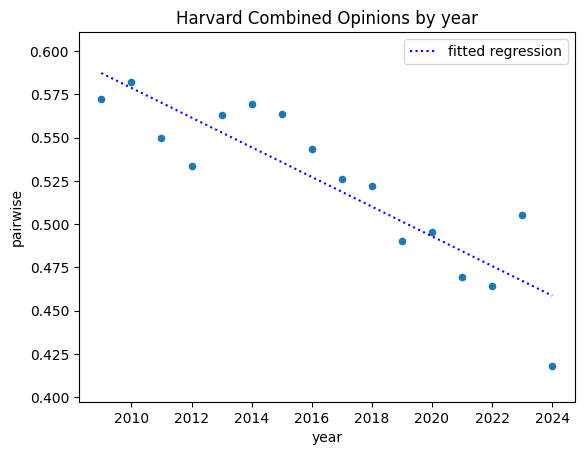

In [35]:
import matplotlib.pyplot as plt
from scipy.stats import linregress

x = results_df['year']
y = results_df['pairwise']

slope, intercept, r_value, p_value, std_err = linregress(x, y)

results_df.plot(x="year", y="pairwise", kind="scatter")

plt.plot(x, intercept + slope*x, 'b:', label='fitted regression')

plt.title("Harvard Combined Opinions by year")
plt.legend(loc='upper right')
plt.ylim(min(y)*0.95, max(y)*1.05)
plt.show()

mentions-norm slope:0.05080, int:0.34315, r:0.85692, p:0.00002, se:0.00817, x:range(0, 16)
pairwise slope:-0.00857, int:0.58725, r:-0.88474, p:0.00001, se:0.00121, x:range(0, 16)


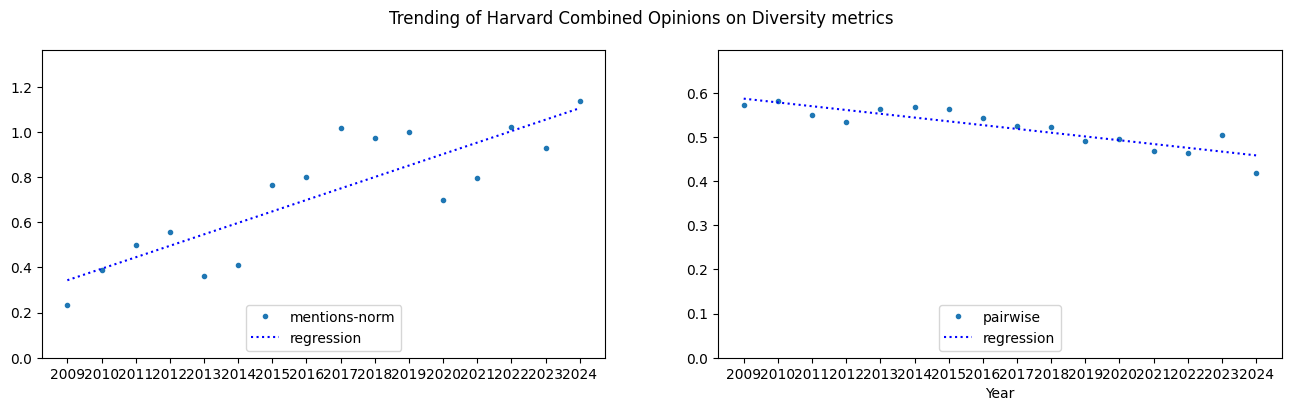

In [36]:
# Select the columns to plot
columns = ["mentions-norm", "pairwise"]

# Create a figure with subplots
fig, axs = plt.subplots(nrows=1, ncols=len(columns), sharex=True, figsize=(16,4))

# Loop through the columns and plot each one
for ax, column in zip(axs, columns):
    # Select the data for the current column
    x = range(len(results_df.index))
    y = results_df[column]
     
    # Calculate the linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    
    print("{} slope:{:.5f}, int:{:.5f}, r:{:.5f}, p:{:.5f}, se:{:.5f}, x:{}".format(
            column, slope, intercept, r_value, p_value, std_err, x))

    # Plot the data and the linear regression line
    results_df[column].plot(ax=ax, style=".", x=x, y=y, label=column)
    ax.plot(x, intercept + slope*x, 'b:', label='regression')
    ax.set_ylim(0, max(y)*1.2)
    
    # Add a legend
    ax.legend(loc='lower center')

    # Add x-label for the years
    ax.set_xticks(results_df.index)
    ax.set_xticklabels(results_df.year)
    
plt.xlabel("Year")
plt.suptitle("Trending of Harvard Combined Opinions on Diversity metrics")
plt.show()

In [38]:
from scipy.stats import t, linregress

x = results_df['year']
y = results_df['pairwise']

slope, intercept, r_value, p_value, std_err = linregress(x, y)

confidence_level = 0.95
degrees_of_freedom = len(x) - 2
t_value = t.ppf((1 + confidence_level) / 2, degrees_of_freedom)

margin_of_error = t_value * std_err

ci_lower = slope - margin_of_error
ci_upper = slope + margin_of_error

print(f"Slope: {slope:.5f}")
print(f"95% Confidence Interval: ({ci_lower:.5f}, {ci_upper:.5f})")
print(f"Standard Error: {std_err:.5f}")
print(f"P-value: {p_value:.5f}")

Slope: -0.00857
95% Confidence Interval: (-0.01116, -0.00598)
Standard Error: 0.00121
P-value: 0.00001
